# RIST Internship Test - Nichita Uțiu
In this document we will try to train a model to predict the type of a sorting algorithm based on a visual representation of it over 42 iterations on a vector of 10 elements(each iteration being a swap).

In [1]:
%matplotlib inline
# import needed libraries
# pandas
import pandas as pd

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# needed for image export
import PIL

# sklearn
from sklearn import preprocessing

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

## 1. Extracting the Data

In [2]:
algorithms_df = pd.read_csv('./data.csv')  # load the data from  the csv
algorithms_df.describe()  # view a short summary

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.500000,0.492175,0.498129,0.512111,0.500150,0.497343,0.503398,0.498808,0.489210,0.510043,...,0.499388,0.500035,0.500087,0.498844,0.497845,0.497845,0.498844,0.500087,0.500035,0.499388
std,2.872425,0.293948,0.290994,0.294248,0.290129,0.280255,0.288480,0.290329,0.290039,0.285080,...,0.416720,0.337148,0.261106,0.194865,0.151147,0.151147,0.194865,0.261106,0.337148,0.416720
min,0.000000,0.000400,0.000500,0.000300,0.001200,0.000300,0.000000,0.000100,0.000400,0.001800,...,0.000000,0.002900,0.015400,0.062500,0.085000,0.085000,0.062500,0.015400,0.002900,0.000000
25%,2.000000,0.232000,0.253100,0.253100,0.253975,0.259150,0.254000,0.237625,0.243000,0.268175,...,0.065600,0.163250,0.256525,0.341550,0.392675,0.392675,0.341550,0.256525,0.163250,0.065600
50%,4.500000,0.491900,0.490000,0.512050,0.494800,0.496650,0.512950,0.500700,0.483250,0.513550,...,0.458600,0.486250,0.506850,0.502200,0.497650,0.497650,0.502200,0.506850,0.486250,0.458600
75%,7.000000,0.751150,0.750525,0.771700,0.752225,0.735500,0.749125,0.746925,0.732625,0.750600,...,0.933675,0.842000,0.738300,0.650725,0.607250,0.607250,0.650725,0.738300,0.842000,0.933675
max,9.000000,1.000000,0.997700,0.999400,0.999800,0.996100,0.997400,0.998200,0.999300,0.999500,...,1.000000,0.993900,0.987100,0.942800,0.890600,0.890600,0.942800,0.987100,0.993900,1.000000


### 1.1 Splitting and looking at the data

In [3]:
Y = algorithms_df['label'].astype(int)  # the labels
X = algorithms_df.drop('label', axis=1)  # everyhing but the labels

# count by label
print("Number of labels = {}".format(Y.unique().size))

# iterate over the label,count pairs
# use sort_index as value_counts returns them unordered
for ind, cnt in Y.value_counts().sort_index().iteritems():
    print("Samples with label {}: {}".format(ind, cnt))

Number of labels = 10
Samples with label 0: 1000
Samples with label 1: 1000
Samples with label 2: 1000
Samples with label 3: 1000
Samples with label 4: 1000
Samples with label 5: 1000
Samples with label 6: 1000
Samples with label 7: 1000
Samples with label 8: 1000
Samples with label 9: 1000


## 2. Sample inspection

In [4]:
def get_order(arr):
    """Returns whether the elements of the given numpy
    array are ascending, descending or unordered.
    
    :return `-1` if descending, `1` if ascending, `0` if
    ordered
    """
    # compare elements pairwise
    # using numpy for vectorisation
    if np.all(arr[:-1] <= arr[1:]):
        return 1 # ascending 
    if np.all(arr[:-1] >= arr[1:]):
        return -1 # descending 
    return 0

def get_samp_order(samp, width):
    """Recives a sample and returns it's last row's
    order. Receives the width of the rows, considering
    the image is unrolled."""
    return get_order(samp[-width:])

def get_image_from_sample(samp, width):
    """Returns a PIL grayscale image from the sample"""
    # normalize the values to a set of equally spaced values
    # in the (0, 255) interval, to maximize visibility
    # we'll be using sklearn's label encoder for this
    
    le = preprocessing.LabelEncoder()
    norm_samp = le.fit_transform(samp) * 255 / (width-1)
    norm_samp = norm_samp.astype('uint8')
    
    # convert the array to a pil "luminance" image
    img =  PIL.Image.new('L', (width, samp.size // width))  # greyscale
    img.putdata(norm_samp)
    return img

**Exmaple:**

Sample 234 order: 1 
Last row = [ 0.056   0.0636  0.16    0.4325  0.4564  0.5976  0.6092  0.6958  0.7046
  0.8454]


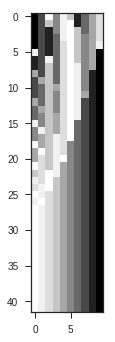

In [5]:
SAMPLE_IND = 234
IMG_WIDTH = 10

# get the sample
sample = X.iloc[SAMPLE_IND].values

order = get_samp_order(sample, IMG_WIDTH)
print("Sample {} order: {} ".format(SAMPLE_IND, order))
print("Last row = {}".format(sample[-IMG_WIDTH:]))  # get the last row

# get image from array
img = get_image_from_sample(sample, IMG_WIDTH)
plt.imshow(img)

# save to png
img.save("algo.png")

## 3. Feature extraction
### 3.1 FTD, FTP, NIT, RPA
#### 3.1.1 Extraction

In [6]:
def extract_ftds(samps, width):
    """Extracts for each sample, the first row where
    each each element changes its initial position.
    
    :returns a matrix of where each row is the features
    of each sample
    """
    # define the function for a single row
    def extract_ftd(samp):
        img = samp.reshape((-1, width)) # reverse into a matrix
        # check what elements on each row are dfferent to the first
        # that means that the first True value is the first swap
        changes = img != img[0]
        # return the row index of the change
        return np.argmax(changes, axis=0)
    # vectorize it
    return np.apply_along_axis(extract_ftd, 1, samps)
 
    
def extract_ftps(samps, width):
    """Extracts for each sample, the first row where
    each element reaches it's final position.
    
    :returns a matrix of where each row is the features
    of each sample"""
    # same as above
    def extract_ftp(samp):
        img = samp.reshape((-1, width))
        # however this time check them in reverse
        changes = (img != img[-1])[::-1, :]
        # return the row index of the change
        # substract from len to get the actual postion
        return changes.shape[0] - np.argmax(changes, axis=0)

    return np.apply_along_axis(extract_ftp, 1, samps)


def extract_rpas(samps, width):
    """Extracts for each sample, the area of image
    where the algorithm is active.
    
    :returns a matrix of the areas for each
    corresponding row"""
    # use the ftp features, sum them to get the inactive
    # area and substract it from the total
    # note: the vectorized computation is fast enough
    # not to warrant precalculating ftp
    inactive_area = extract_ftps(samps, width).sum(axis=1)
    
    # substract them from the total size of an image
    # also add a dimension to convert it to a matrix
    return (samps[0].size - inactive_area)[:, np.newaxis]


def extract_nits(samps, width):
    """Extract, for each sample, the number of iterations
    needed to reach the end of the algorithm
    
    :returns a matrix of the values, each row orresponding to
    a sample
    """
    # compute it similarly to the ftp values, but find the 
    # first row not equal to the last one
    def extract_nit(samp):
        img = samp.reshape((-1, width))
        # any item that is different from the final state
        # means the algorithm is still active
        changes = np.any((img != img[-1])[::-1, :], axis=1)
        return changes.size - np.argmax(changes)
    
    # vectorize and turn back to a matrix
    return np.apply_along_axis(extract_nit, 1, samps)[:, np.newaxis]

#### 3.1.2 Example
Extract FTD, FTP, NIT and RPA for *SAMPLE_INDEX*

Extracted features:
FTP = [[27 27 25 23 21 18 15 12  8  5]]
FTD = [[5 9 1 3 4 1 2 3 8 4]]
NIT = [[27]]
RPA = [[239]]


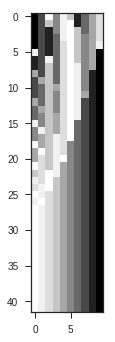

In [7]:
sample = X.iloc[SAMPLE_IND].values[np.newaxis, :]

ftp = extract_ftps(sample, IMG_WIDTH)
ftd = extract_ftds(sample, IMG_WIDTH)
nit = extract_nits(sample, IMG_WIDTH)
rpa = extract_rpas(sample, IMG_WIDTH)

print("Extracted features:")
print("FTP = {}".format(ftp))
print("FTD = {}".format(ftd))
print("NIT = {}".format(nit))
print("RPA = {}".format(rpa))

plt.imshow(img);

### 3.2 Additional Features
To extract more info from he given features and increase the variance of our samples, we can:

* Add a one-hot encoded feature from the order of the last row. This one would be linearly correlated to whether the algorithm is ascending or descending.(**Note:** Is this considered cheating?)

* Compute for each element, the time between the first displacement and the time it reaches its last position.
(**Note**: Is there an issue of this being a linear combination of the orther features?)

* Compute the distance of each swap between every consecutive row. Diferent algorithm might do swaps differently.

* Lastly, it could probably help if the values are normalize to an interval and equally spaced so that we extract only the relative order and not the absolut values, reducing noise.

#### 3.2.1 Implementation:

In [8]:
def extract_orders_one_hot(samps, width):
    """Extracts the order of the samples as 
    a matrix of one-hot-encoded values of the 
    order of the last row
    
    :returns a matrix of the values, each row 
    corresponding to a sample
    """
    
    # use the predefined function, but vectorize it
    # needs positive values so add one
    row_func = lambda samp: get_samp_order(samp, width) + 1
    samp_orders = np.apply_along_axis(row_func, 1, samps)
    
    # convert it back to a matrix from a vector
    samp_orders = samp_orders.reshape((-1, 1))
    
    # use sklearn for one-hot encoding
    # do not generate sparse matrix
    oh_encoder = preprocessing.OneHotEncoder(sparse=False)
    return oh_encoder.fit_transform(samp_orders)


def extract_displacements(samps, width):
    """Returns the displacement for each element 
    of the array(the differene between FTD and FTP)
    
    :returns a matrix of the features for each
    element of the array on each row"""
    return extract_ftps(samps, width) - \
        extract_ftds(samps, width)


def extract_swap_dists(samps, width):
    """Extracts the distances of swaps between
    consecutive rows. The distance is 0 if no 
    swap occured.
    
    :returns a matrix of the values, each row 
    having nrrows-1 columns, each representing 
    the distance of a swap."""
    def extract_swap_dist(samp):
        img = samp.reshape((-1, width))
        # each row will have a truth value where
        # the swapped values are
        swaps = img[:-1] != img[1:]
        
        # every pair is the positions on the row
        # so sumbstract them to get the distance
        pos = np.nonzero(swaps)[1]
        swap_lengths = np.abs(pos[::2] - pos[1::2])
        
        # pad the result with 0 to make them of equal 
        result = np.zeros(img.shape[0]-1)  # length(41 in this case)
        result[:swap_lengths.size] = swap_lengths
        return result
    
    # vectorize and turn back to a matrix
    return np.apply_along_axis(extract_swap_dist, 1, samps)


def extract_norm_samps(samps, width):
    """For each image, extract the pixel values,
    but normalized to the integer inteval 1, 2 ...width.
    
    :returns a matrix of the normlized samples, each row
    corresponding to each sample"""
    def extract_norm_samp(samp):
        # normalize using sklearn's label encoder
        le = preprocessing.LabelEncoder()
        return le.fit_transform(samp)
    
    return np.apply_along_axis(extract_norm_samp, 1, samps)

#### 3.2.2 Example
Extract the bonus features for *SAMPLE_INDEX*

Extracted features:
ORDERS = [[ 1.]]
DISPLACEMENTS = [[22 18 24 20 17 17 13  9  0  1]]
DISTS = [[ 3.  4.  4.  5.  9.  2.  4.  8.  1.  2.  4.  7.  1.  2.  6.  1.  2.  5.
   1.  3.  4.  2.  3.  1.  2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.]]
NORM = [[9 7 0 5 1 3 8 6 4 2 9 7 3 5 1 0 8 6 4 2 9 7 8 5 1 0 3 6 4 2 9 7 8 6 1 0 3
  5 4 2 9 7 8 6 2 0 3 5 4 1 1 7 8 6 2 0 3 5 4 9 8 7 1 6 2 0 3 5 4 9 8 7 3 6
  2 0 1 5 4 9 4 7 3 6 2 0 1 5 8 9 7 4 3 6 2 0 1 5 8 9 7 6 3 4 2 0 1 5 8 9 7
  6 3 5 2 0 1 4 8 9 4 6 3 5 2 0 1 7 8 9 6 4 3 5 2 0 1 7 8 9 6 5 3 4 2 0 1 7
  8 9 1 5 3 4 2 0 6 7 8 9 5 1 3 4 2 0 6 7 8 9 5 4 3 1 2 0 6 7 8 9 0 4 3 1 2
  5 6 7 8 9 4 0 3 1 2 5 6 7 8 9 4 2 3 1 0 5 6 7 8 9 0 2 3 1 4 5 6 7 8 9 3 2
  0 1 4 5 6 7 8 9 1 2 0 3 4 5 6 7 8 9 2 1 0 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8
  9 1 0 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5
  6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2
  3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 

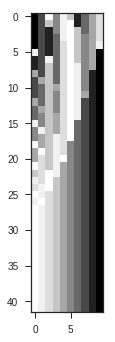

In [9]:
sample = X.iloc[SAMPLE_IND].values[np.newaxis, :]

orders_one_hot = extract_orders_one_hot(sample, IMG_WIDTH)
displacements = extract_displacements(sample, IMG_WIDTH)
dists = extract_swap_dists(sample, IMG_WIDTH)
norm = extract_norm_samps(sample, IMG_WIDTH)

print("Extracted features:")
print("ORDERS = {}".format(orders_one_hot))
print("DISPLACEMENTS = {}".format(displacements))
print("DISTS = {}".format(dists))
print("NORM = {}".format(norm))

plt.imshow(img);  # image for reference